# Customer Review Analysis and Product Categorization
## Using NLP and LLMs

In [3]:
# Required Libraries
# Core data processing
import pandas as pd
import numpy as np

# NLP
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Text processing
import re

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os
import joblib

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

/opt/anaconda3/envs/project3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brunoaugusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brunoaugusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data Loading 

In [4]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from CSV file with proper error handling
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        pd.DataFrame: Loaded dataframe
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}")
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None


In [5]:
# File paths
file_paths = {
    'main': '1429_1.csv',
    'may19': 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv',
    'base': 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'
}

In [11]:
# Load datasets
main_df = load_data(file_paths['main'])
may19_df = load_data(file_paths['may19'])
base_df = load_data(file_paths['base'])

/var/folders/4r/064fnvjs2j9g2l9n63gy6k0w0000gn/T/ipykernel_10012/1974511506.py:12: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded 1429_1.csv
Successfully loaded Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
Successfully loaded Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv


In [15]:
#helper function to get summary of the dataframe 

def get_summary(df: pd.DataFrame) -> None:
    """
    Get summary of the dataframe
    
    Args:
        df: DataFrame to get summary of
    """
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns}")
    print(f"Info: {df.info()}")
    print(f"Describe: {df.describe()}")
    print(f"Head: {df.head()}")
    print(f"Tail: {df.tail()}")


In [16]:

# Get summary of the datasets
get_summary(main_df)




Shape: (34660, 21)
Columns: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  o

In [17]:
# Get summary of the May 2019 dataframe
get_summary(may19_df)


Shape: (28332, 24)
Columns: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories    

In [18]:
# Get summary of the base dataframe
get_summary(base_df)


Shape: (5000, 24)
Columns: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories         

# 1.1 Data cleaning

In [19]:
# helper function remove empty reviews and rating columns
def remove_empty_reviews(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows with empty reviews and rating columns
    
    Args:
        df: DataFrame to remove empty reviews and rating columns from
        
    Returns:
        pd.DataFrame: DataFrame with empty reviews and rating columns removed
    """
    df = df.dropna(subset=['reviews.text', 'reviews.rating'])
    return df

# Remove empty reviews and rating columns from the main dataframe
main_df = remove_empty_reviews(main_df)

# Remove empty reviews and rating columns from the May 2019 dataframe
may19_df = remove_empty_reviews(may19_df)

# Remove empty reviews and rating columns from the base dataframe
base_df = remove_empty_reviews(base_df)



In [21]:
# Get summary of the main dataframe
get_summary(main_df)


Shape: (34626, 21)
Columns: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 34626 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34626 non-null  object 
 1   name                  27867 non-null  object 
 2   asins                 34624 non-null  object 
 3   brand                 34626 non-null  object 
 4   categories            34626 non-null  object 
 5   keys                  34626 non-null  object 
 6   manufacturer          34626 non-null  object

In [22]:
# Get summary of the May 2019 dataframe
get_summary(may19_df)

Shape: (28332, 24)
Columns: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories    

In [23]:
# Get summary of the base dataframe
get_summary(base_df)

Shape: (5000, 24)
Columns: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories         

In [25]:
#create the labels for the ratings for sentiment classes positive, negative and neutral
def create_sentiment(rating: int) -> str:
    """
    Create sentiment labels based on rating
    
    Args:
        rating: Rating to create sentiment for
        
    Returns:
        str: Sentiment label
    """
    if rating > 3:
        return 'positive'
    elif rating < 3:
        return 'negative'
    else:
        return 'neutral'
    
# Apply sentiment labels to the main dataframe
main_df.loc[:, 'sentiment'] = main_df['reviews.rating'].apply(create_sentiment)

# Apply sentiment labels to the May 2019 dataframe
may19_df.loc[:, 'sentiment'] = may19_df['reviews.rating'].apply(create_sentiment)

# Apply sentiment labels to the base dataframe
base_df.loc[:, 'sentiment'] = base_df['reviews.rating'].apply(create_sentiment)


In [26]:
get_summary(main_df)

Shape: (34626, 22)
Columns: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sentiment'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 34626 entries, 0 to 34659
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34626 non-null  object 
 1   name                  27867 non-null  object 
 2   asins                 34624 non-null  object 
 3   brand                 34626 non-null  object 
 4   categories            34626 non-null  object 
 5   keys                  34626 non-null  object 
 6   manufacturer          34626 non

In [30]:
# Get sentiment of the main dataframe
main_df['sentiment'].value_counts()

sentiment
positive    32315
neutral      1499
negative      812
Name: count, dtype: int64

In [29]:
# Get sentiment value counts for the May 2019 dataframe
may19_df['sentiment'].value_counts()



sentiment
positive    25545
negative     1581
neutral      1206
Name: count, dtype: int64

In [31]:
# Get sentiment value counts for the base dataframe
base_df['sentiment'].value_counts()

sentiment
positive    4686
neutral      197
negative     117
Name: count, dtype: int64

In [33]:
#save the cleaned dataframes to csv files
def save_data(df: pd.DataFrame, file_path: str) -> None:
    """
    Save dataframe to CSV file
    
    Args:
        df: DataFrame to save
        file_path: Path to save the CSV file
    """
    df.to_csv(file_path, index=False)
    print(f"Successfully saved {file_path}")

# Save the main dataframe to a CSV file
save_data(main_df, 'main_cleaned.csv')

# Save the May 2019 dataframe to a CSV file
save_data(may19_df, 'may19_cleaned.csv')

# Save the base dataframe to a CSV file
save_data(base_df, 'base_cleaned.csv')


Successfully saved main_cleaned.csv
Successfully saved may19_cleaned.csv
Successfully saved base_cleaned.csv


In [34]:
# Load all cleaned datasets for further processing and analysis
main_df = load_data('main_cleaned.csv')
may19_df = load_data('may19_cleaned.csv')
base_df = load_data('base_cleaned.csv')


/var/folders/4r/064fnvjs2j9g2l9n63gy6k0w0000gn/T/ipykernel_10012/1974511506.py:12: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded main_cleaned.csv
Successfully loaded may19_cleaned.csv
Successfully loaded base_cleaned.csv


# 1.2 Exploratory data Analysis

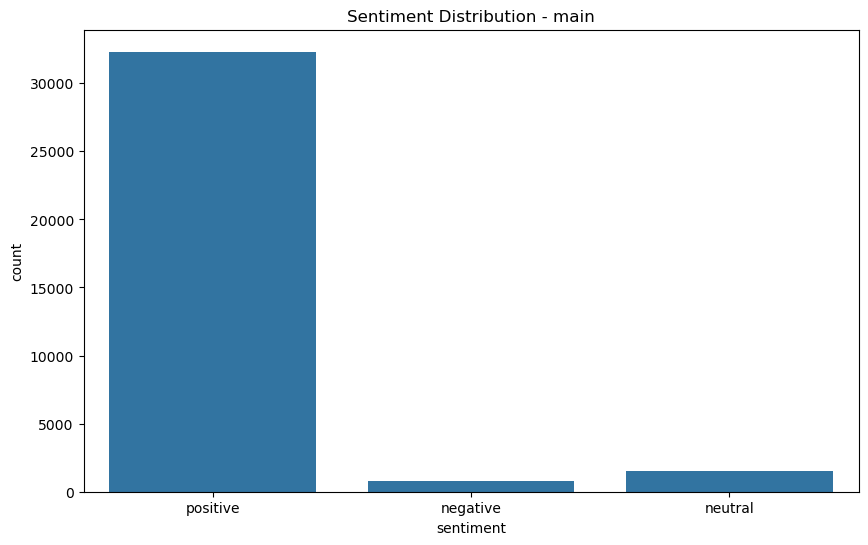

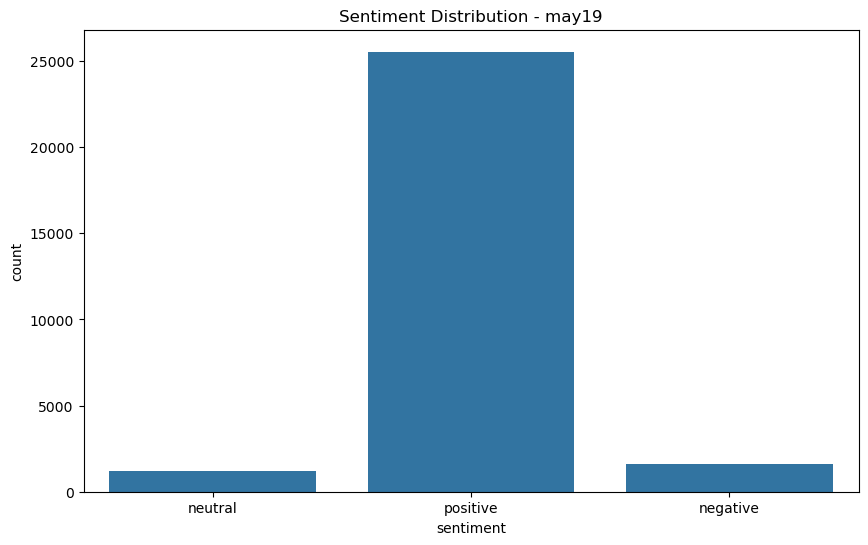

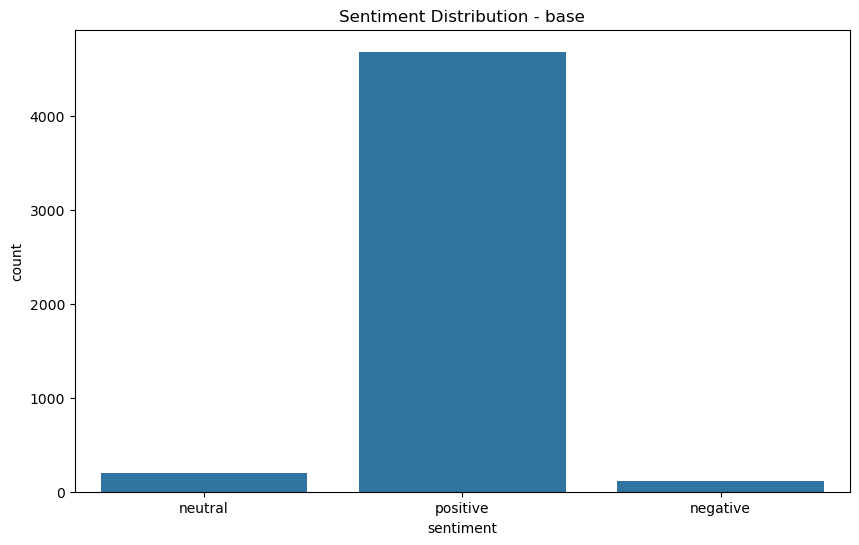

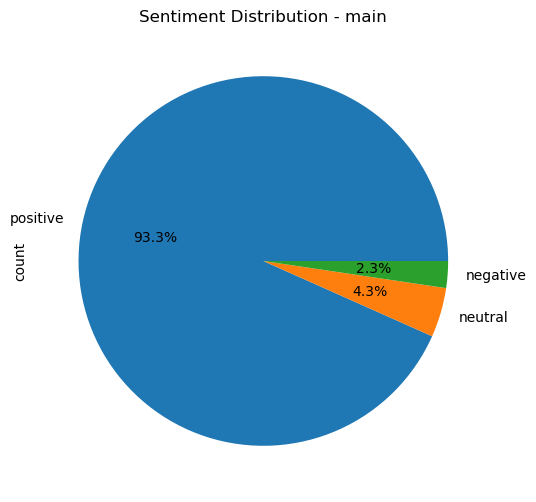

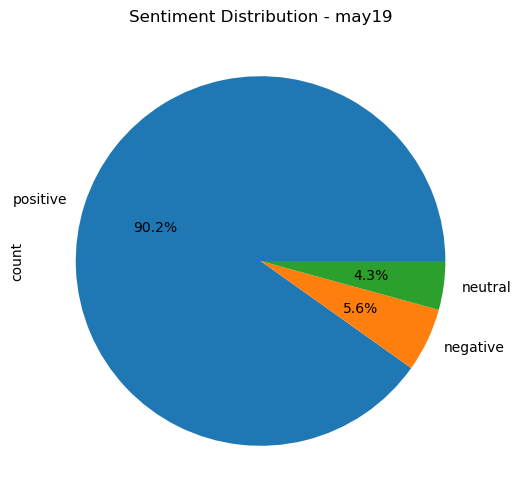

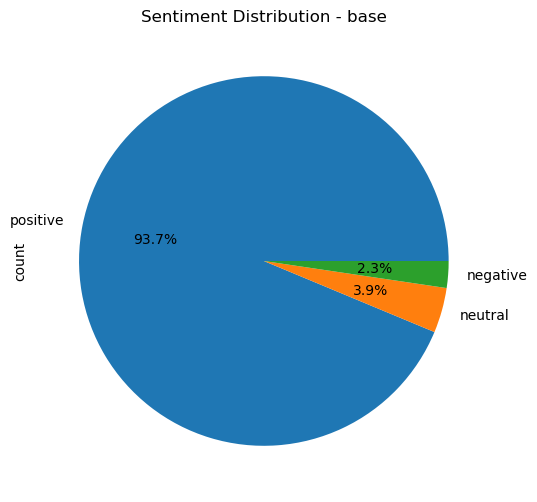

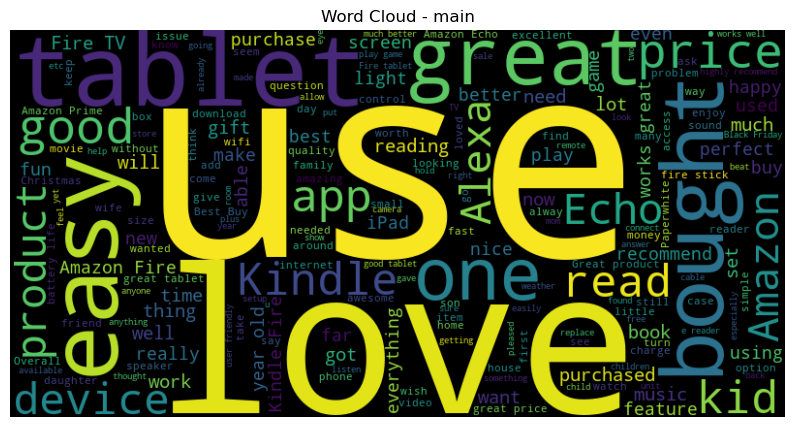

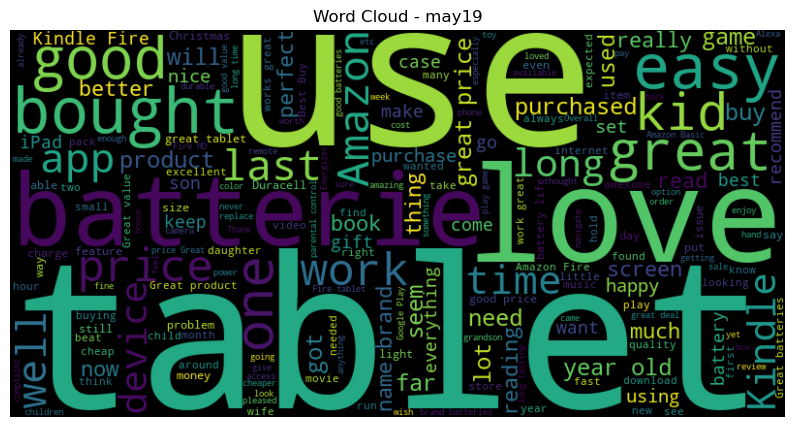

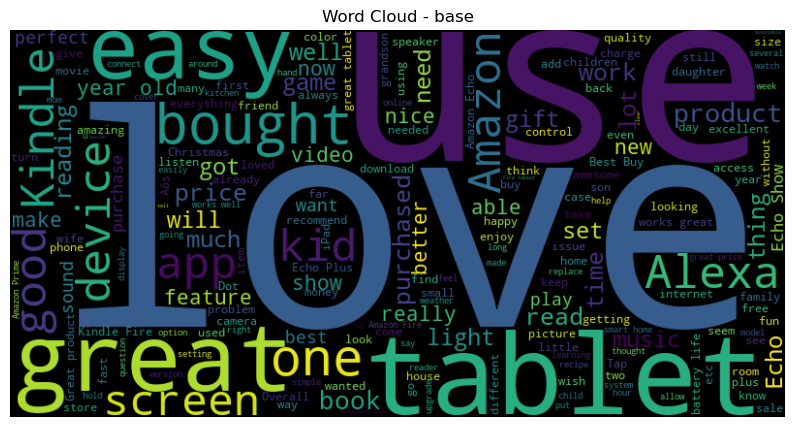

In [36]:
# Create a dictionary of cleaned datasets
datasets_clean = {
    'main': main_df,
    'may19': may19_df,
    'base': base_df
}

# Exploratory Analysis
def plot_sentiment_distribution(df, name):
    """Plot sentiment distribution"""
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x='sentiment')
    plt.title(f'Sentiment Distribution - {name}')
    plt.show()

# Plot sentiment distribution for each dataset
for name, df in datasets_clean.items():
    plot_sentiment_distribution(df, name)
    
# Visualize class distribution pie chart for each dataset
def plot_class_distribution(df, name):
    plt.figure(figsize=(6, 6))
    df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Sentiment Distribution - {name}')
    plt.show()

# Plot class distribution for each dataset
for name, df in datasets_clean.items():
    plot_class_distribution(df, name)

# Visualize word cloud for each sentiment class

def plot_word_cloud(df, name):
    """Plot word cloud"""
    reviews = df['reviews.text'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400).generate(reviews)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {name}')
    plt.show()

# Plot word cloud for each dataset
for name, df in datasets_clean.items():
    plot_word_cloud(df, name)


# 1.2 Preprocessing for Modeling

In [41]:
from transformers import BertTokenizer

def preprocess_for_bert(texts, max_len=128):
    """
    Preprocess text for BERT model
    
    Args:
        texts: List of texts to preprocess
        max_len: Maximum length of the sequences
        
    Returns:
        input_ids: List of token ids
        attention_masks: List of attention masks
    """
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,                      # Sentence to encode
            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
            max_length=max_len,        # Pad & truncate all sentences
            truncation=True,           # Explicitly truncate to max length
            padding='max_length',      # Pad to max length
            return_attention_mask=True, # Construct attention masks
            return_tensors='pt',       # Return pytorch tensors
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return input_ids, attention_masks


In [42]:
# Apply the preprocess_for_bert function to the reviews.text column of cleaned datasets
for name, df in datasets_clean.items():
    input_ids, attention_masks = preprocess_for_bert(df['reviews.text'], max_len=128)
    df['input_ids'] = input_ids
    df['attention_masks'] = attention_masks

# Save the cleaned datasets with BERT input ids and attention masks
for name, df in datasets_clean.items():
    save_data(df, f'{name}_cleaned_bert.csv')
    

Successfully saved main_cleaned_bert.csv
Successfully saved may19_cleaned_bert.csv
Successfully saved base_cleaned_bert.csv


In [43]:
# Load all cleaned datasets with BERT input ids and attention masks for further processing and analysis
main_df = load_data('main_cleaned_bert.csv')
may19_df = load_data('may19_cleaned_bert.csv')
base_df = load_data('base_cleaned_bert.csv')

# Create a dictionary of cleaned datasets with BERT input ids and attention masks
datasets_clean_bert = {
    'main': main_df,
    'may19': may19_df,
    'base': base_df
}

# Get summary of the datasets with BERT input ids and attention masks
for name, df in datasets_clean_bert.items():
    get_summary(df)

/var/folders/4r/064fnvjs2j9g2l9n63gy6k0w0000gn/T/ipykernel_10012/1974511506.py:12: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded main_cleaned_bert.csv
Successfully loaded may19_cleaned_bert.csv
Successfully loaded base_cleaned_bert.csv
Shape: (34626, 24)
Columns: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sentiment', 'input_ids',
       'attention_masks'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34626 entries, 0 to 34625
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34626 non-null  object 
 1   name                  27867 non-null  object 
 2   asins                 34624 non-null  object 
 3   brand        

## 2. Data splitting

In [44]:
# Split the cleaned bert dataset into training and testing sets

def split_train_test(df: pd.DataFrame, test_size: float=0.2, random_state: int=42):
    """
    Split the dataframe into training and testing sets
    
    Args:
        df: DataFrame to split
        test_size: Size of the testing set
        random_state: Random state for reproducibility
        
    Returns:
        pd.DataFrame: Training set
        pd.DataFrame: Testing set
    """
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df, test_df

# Split the cleaned datasets with BERT input ids and attention masks into training and testing sets
train_test_datasets = {}
for name, df in datasets_clean_bert.items():
    train_df, test_df = split_train_test(df)
    train_test_datasets[name] = {
        'train': train_df,
        'test': test_df
    }

# Save the training and testing datasets
for name, data in train_test_datasets.items():
    for split, df in data.items():
        save_data(df, f'{name}_{split}.csv')







Successfully saved main_train.csv
Successfully saved main_test.csv
Successfully saved may19_train.csv
Successfully saved may19_test.csv
Successfully saved base_train.csv
Successfully saved base_test.csv


In [45]:
# Load the training and testing datasets for further processing and analysis
train_main_df = load_data('main_train.csv')
test_main_df = load_data('main_test.csv')
train_may19_df = load_data('may19_train.csv')
test_may19_df = load_data('may19_test.csv')
train_base_df = load_data('base_train.csv')
test_base_df = load_data('base_test.csv')

analyze_datasets = {
    'main': {
        'train': train_main_df,
        'test': test_main_df
    },
    'may19': {
        'train': train_may19_df,
        'test': test_may19_df
    },
    'base': {
        'train': train_base_df,
        'test': test_base_df
    }
}

# Get summary of the training and testing datasets
for name, data in analyze_datasets.items():
    for split, df in data.items():
        get_summary(df)


Successfully loaded main_train.csv
Successfully loaded main_test.csv
Successfully loaded may19_train.csv
Successfully loaded may19_test.csv
Successfully loaded base_train.csv
Successfully loaded base_test.csv
Shape: (27700, 24)
Columns: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sentiment', 'input_ids',
       'attention_masks'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27700 entries, 0 to 27699
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27700 non-null  object 
 1   name                  22341 non-n

# 3. Sentiment Analysis using LLM - BERT Model

In [ ]:
class AmazonReviewsDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        input_ids = self.dataframe.iloc[idx]['input_ids']
        attention_mask = self.dataframe.iloc[idx]['attention_mask']
        label = self.dataframe.iloc[idx]['sentiment']
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
from torch.utils.data import DataLoader

# Assuming 'test_main_df' is your test dataframe
test_dataset = AmazonReviewsDataset(test_main_df)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
from transformers import BertForSequenceClassification

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Adjust num_labels as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/project3/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#Get predictions from the model for the test dataset
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
    
    return predictions



In [ ]:
predictions = get_predictions(model, test_loader)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'test_main_df' has a 'sentiment' column with true labels
true_labels = test_main_df['sentiment'].values
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))